In [96]:
from pathlib import Path
from collections import OrderedDict

import tqdm
import numpy as np
import pandas as pd
import empyrical
import seaborn as sns

In [43]:
dataset_dir = Path('dataset/ftx')
with open('asset_list_ftx.txt', 'r') as f:
    ASSET_NAMES = f.read().splitlines()

In [44]:
def prepare_data(asset_df):
    # Import datetime
    asset_df['time'] = pd.to_datetime(asset_df['time'])
    
    # Create volume columns
    asset_df = asset_df.rename(columns={'Volume USDT': 'volume'})
    
    # Drop unusal columns
    asset_df = asset_df[['time', 'open', 'high', 'low', 'close']]
    
    # Sort datetime by ascending
    asset_df = asset_df.iloc[::-1].reset_index(drop=True)
    
#     asset_df = asset_df[['time', 'close']]
    asset_df.set_index('time', inplace=True)
    return asset_df

In [45]:
asset_path = 'dataset/h1/Binance_LTCUSDT_1h.csv'
asset_df = pd.read_csv(asset_path)
asset_df = prepare_data(asset_df)

asset_df

,open,high,low,close
time,,,,
2017-09-22 19:00:00,276.00,301.52,220.03,246.00
2017-12-13 03:00:00,274.00,288.00,274.00,276.00
2017-12-13 04:00:00,276.00,288.00,269.99,279.00
2017-12-13 05:00:00,279.00,330.00,279.00,302.00
2017-12-13 06:00:00,302.00,304.11,286.00,291.13
...,...,...,...,...
2021-07-30 20:00:00,140.87,143.79,140.68,142.37
2021-07-30 21:00:00,142.39,144.39,142.38,143.50
2021-07-30 22:00:00,143.53,145.21,142.96,144.21


### Resample to expect timeframe

In [46]:
df = asset_df.head(10)
df

,open,high,low,close
time,,,,
2017-09-22 19:00:00,276.00,301.52,220.03,246.00
2017-12-13 03:00:00,274.00,288.00,274.00,276.00
2017-12-13 04:00:00,276.00,288.00,269.99,279.00
2017-12-13 05:00:00,279.00,330.00,279.00,302.00
2017-12-13 06:00:00,302.00,304.11,286.00,291.13
2017-12-13 07:00:00,291.13,296.00,285.00,290.00
2017-12-13 08:00:00,287.00,290.00,280.10,280.10
2017-12-13 09:00:00,280.10,288.96,278.00,284.19
2017-12-13 10:00:00,284.19,287.40,275.20,284.50


In [47]:
[asset_df.head(1).index.max()]

[Timestamp('2017-09-22 19:00:00')]

In [48]:
def ohlc_resampler(df):
#     print(df)
#     print('type', type(df))
#     print('length', len(df))
#     print(df.index.min())
    if len(df) == 0:
        return pd.Series({
            'open': np.NaN,
            'high': np.NaN,
            'low': np.NaN,
            'close':np.NaN
        })
    return pd.Series({
        'open': df.loc[df.index.min(), 'open'],
        'high': df['high'].max(),
        'low': df['low'].min(),
        'close': df.loc[df.index.max(), 'close']
    })
def resample_ohlc(asset_df, timeframe):
    return asset_df.groupby(pd.Grouper(freq=timeframe)).apply(ohlc_resampler)

asset_df = resample_ohlc(asset_df, timeframe='D')

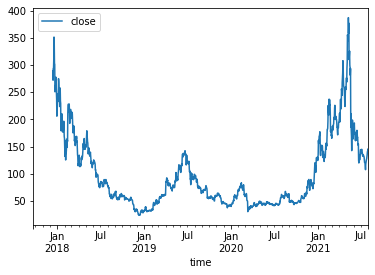

In [49]:
asset_df.plot(y='close')

In [50]:
asset_df

,open,high,low,close
time,,,,
2017-09-22,276.00,301.52,220.03,246.00
2017-09-23,NaN,NaN,NaN,NaN
2017-09-24,NaN,NaN,NaN,NaN
2017-09-25,NaN,NaN,NaN,NaN
2017-09-26,NaN,NaN,NaN,NaN
...,...,...,...,...
2021-07-27,131.06,135.12,127.27,134.74
2021-07-28,134.73,142.00,132.39,140.42
2021-07-29,140.48,143.00,136.55,141.44


### Return

In [51]:
def calculate_return(asset_df):
    asset_df['return'] = (asset_df['close'] - asset_df['close'].shift(1)) / asset_df['close'].shift(1)

In [52]:
calculate_return(asset_df)

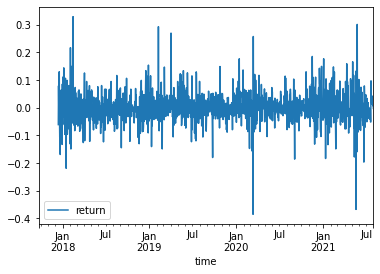

In [53]:
asset_df.plot(y='return')

### Drawdown

In [54]:
empyrical.max_drawdown(asset_df['return'].dropna())

-0.9344318181818182

In [55]:
def calculate_drawdown(asset_df):
    previous_peak = asset_df['high'].cummax()
    asset_df['drawdown'] = (asset_df['low'] - previous_peak) / previous_peak

In [56]:
calculate_drawdown(asset_df)

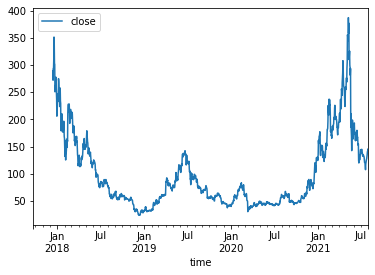

In [57]:
asset_df.plot(y='close')

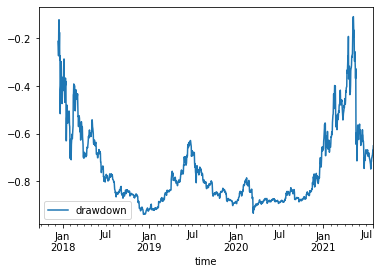

In [58]:
asset_df.plot(y='drawdown')

## Pipeline

In [59]:
def pipeline_data_prep(asset_path, timeframe):

    asset_df = pd.read_csv(asset_path)
    asset_df = prepare_data(asset_df)
    
    asset_df = resample_ohlc(asset_df, timeframe=timeframe)
    
    calculate_return(asset_df)
    calculate_drawdown(asset_df)
    
    return asset_df

In [60]:
sheets = {}
def insert_sheet_df(sheet_name, asset_name, asset_df, indicator_name):
    if sheet_name in sheets:
        return_df = sheets[sheet_name]
        return_df[asset_name] = asset_df[indicator_name]
    else:
        return_df = asset_df[[indicator_name]].rename(columns={indicator_name: asset_name})
        sheets[sheet_name] = return_df


loop = tqdm.tqdm(ASSET_NAMES)
for asset_name in loop:
    loop.set_description(asset_name)
    
    asset_path = list(dataset_dir.glob(f'{asset_name.replace("/", "")}.csv'))[0]
    monthly_asset_df = pipeline_data_prep(asset_path, timeframe='M')
    
    insert_sheet_df('Monthly Return', asset_name, monthly_asset_df, 'return')
    insert_sheet_df('Monthly Drawdown', asset_name, monthly_asset_df, 'drawdown')
    
    yearly_asset_df = pipeline_data_prep(asset_path, timeframe='Y')
    
    insert_sheet_df('Yearly Return', asset_name, yearly_asset_df, 'return')
    insert_sheet_df('Yearly Drawdown', asset_name, yearly_asset_df, 'drawdown')
    

USDTHEDGE/USD: 100%|██████████| 393/393 [00:22<00:00, 17.53it/s]   


In [61]:
sheets['Monthly Drawdown'].T

time,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,...,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31
BTC/USD,-0.147495,-0.242958,-0.373894,-0.408475,-0.470330,-0.477839,-0.443948,-0.316016,-0.683416,-0.499959,...,-0.335404,-0.400621,-0.340464,-0.446390,-0.271220,-0.275664,-0.550757,-0.555859,-0.548692,-0.419406
ETH/USD,NaN,NaN,-0.321279,-0.353429,-0.412156,-0.481762,-0.440248,-0.381056,-0.696753,-0.554656,...,-0.405694,-0.301239,-0.515417,-0.410998,-0.344687,-0.327337,-0.605149,-0.612019,-0.607705,-0.442187
USDT/USD,NaN,NaN,-0.034658,-0.028995,-0.029776,-0.035825,-0.035922,-0.035147,-0.059137,-0.089846,...,-0.051341,-0.051245,-0.054478,-0.052957,-0.051341,-0.058756,-0.051531,-0.049914,-0.050010,-0.049249
FTT/USD,-0.484694,-0.582090,-0.597015,-0.570896,-0.515672,-0.471642,-0.211194,-0.272513,-0.343078,-0.315742,...,-0.292979,-0.306861,-0.564929,-0.691000,-0.405057,-0.339015,-0.639519,-0.654533,-0.630881,-0.457222
BNB/USD,NaN,NaN,NaN,NaN,-0.056205,-0.256315,-0.313653,-0.351094,-0.761772,-0.560336,...,-0.269572,-0.325182,-0.259284,-0.874679,-0.396256,-0.528301,-0.695649,-0.674970,-0.633136,-0.542682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASDHEDGE/USD,NaN,NaN,NaN,NaN,-0.363137,-0.333609,-0.468612,-0.670938,-0.555247,-0.599067,...,-0.793598,-0.806856,-0.883246,-0.991418,-0.998457,-0.997438,-0.996262,-0.993423,-0.993423,-0.993258
USDTHALF/USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017533,...,-0.020949,-0.022021,-0.020949,-0.020949,-0.020591,-0.022498,-0.022021,-0.019757,-0.019757,-0.019757
PRIVHALF/USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.129584,...,-0.219107,-0.148141,-0.216101,-0.332945,-0.153221,-0.198333,-0.373731,-0.399089,-0.409150,-0.344403
XAUTHALF/USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.028589,...,-0.047818,-0.042353,-0.022003,-0.066801,-0.117171,-0.119221,-0.122888,-0.130474,-0.121629,-0.114367


### Format datetime label

In [62]:
for sheet_name, df in sheets.items():
    if 'Yearly' in sheet_name:
        df.index = df.index.strftime('%Y')
    elif 'Monthly' in sheet_name:
        df.index = df.index.strftime('%Y-%m')

### Transpose sheet

In [63]:
for sheet_name, df in sheets.items():
    sheets[sheet_name] = df.T

## Create summary sheet

In [64]:
indicators = ('Average Return', 'Maximum Return', 'Average Drawdown', 'Maximum Drawdown', 'Volatility')
timeframe_labels = ('Daily', 'Monthly', 'Yearly')
timeframe_flags = ('D', 'M', 'Y')
summary_index = pd.MultiIndex.from_product([indicators, timeframe_labels])
summary_df = pd.DataFrame(index=summary_index)
summary_df

Empty DataFrame
Columns: []
Index: [(Average Return, Daily), (Average Return, Monthly), (Average Return, Yearly), (Maximum Return, Daily), (Maximum Return, Monthly), (Maximum Return, Yearly), (Average Drawdown, Daily), (Average Drawdown, Monthly), (Average Drawdown, Yearly), (Maximum Drawdown, Daily), (Maximum Drawdown, Monthly), (Maximum Drawdown, Yearly), (Volatility, Daily), (Volatility, Monthly), (Volatility, Yearly)]

In [65]:
loop = tqdm.tqdm(ASSET_NAMES)

for asset_name in loop:
    loop.set_description(asset_name)
    
    asset_path = list(dataset_dir.glob(f'{asset_name.replace("/", "")}.csv'))[0]
    
    for timeframe_flag, timeframe_label in zip(timeframe_flags, timeframe_labels):
        asset_df = pipeline_data_prep(asset_path, timeframe=timeframe_flag)
        
        # Calculate average return
        summary_df.loc[('Average Return', timeframe_label), asset_name] = asset_df['return'].mean()
        
        # Calculate Maximum return
        summary_df.loc[('Maximum Return', timeframe_label), asset_name] = asset_df['return'].max()

        
        # Calculate average drawdown
        summary_df.loc[('Average Drawdown', timeframe_label), asset_name] = -asset_df['drawdown'].abs().mean()
        
        # Calculate maximum drawdown
        summary_df.loc[('Maximum Drawdown', timeframe_label), asset_name] = asset_df['drawdown'].min()
        
        # Calculate volatility
        summary_df.loc[('Volatility', timeframe_label), asset_name] = asset_df['return'].std()

USDTHEDGE/USD: 100%|██████████| 393/393 [02:21<00:00,  2.78it/s]   


In [66]:
summary_df

BTC/USD   ETH/USD  USDT/USD   FTT/USD   BNB/USD  \
Average Return   Daily    0.002587  0.005306 -0.000001  0.005508  0.007218   
                 Monthly  0.077243  0.157281 -0.000077  0.177767  0.289607   
                 Yearly   1.688316  3.574873  0.001858  3.515008  4.691323   
Maximum Return   Daily    0.194509  0.264253  0.007594  0.319343  0.705555   
                 Monthly  0.470081  0.780623  0.002402  1.340552  3.739549   
                 Yearly   3.042850  4.733494  0.004516  5.337205  7.647320   
Average Drawdown Daily   -0.251006 -0.261945 -0.044238 -0.253506 -0.287790   
                 Monthly -0.374197 -0.427195 -0.048987 -0.414143 -0.448237   
                 Yearly  -0.639302 -0.734226 -0.063735 -0.732547 -0.680601   
Maximum Drawdown Daily   -0.683416 -0.696753 -0.089846 -0.654533 -0.761772   
                 Monthly -0.683416 -0.696753 -0.089846 -0.691000 -0.874679   
                 Yearly  -0.866971 -0.884405 -0.089846 -0.909840 -0.949555   
Volatility       Daily    0.040467  0.054496  0.000882  0.051090  0.068430   
                 Monthly  0.220133  0.294350  0.001238  0.366105  0.849093   
                 Yearly   1.915600  1.638538  0.003759  2.576976  4.180411   

                            SOL/USD  DOGE/USD  MATIC/USD   XRP/USD  RUNE/USD  \
Average Return   Daily     0.012456  0.035590   0.021740  0.007044  0.012002   
                 Monthly   0.517251  0.744787   0.973513  0.281095  0.422394   
                 Yearly   22.198675       NaN  57.544465  2.275128  5.028351   
Maximum Return   Daily     0.460446  4.026996   0.628076  0.566028  0.406042   
                 Monthly   2.123153  5.284119   5.076662  1.806856  2.077749   
                 Yearly   22.198675       NaN  57.544465  2.275128  5.028351   
Average Drawdown Daily    -0.401351 -0.488612  -0.358502 -0.395803 -0.396980   
                 Monthly  -0.626260 -0.745348  -0.639468 -0.562385 -0.643920   
                 Yearly   -0.878845 -0.990246  -0.688848 -0.834862 -0.845211   
Maximum Drawdown Daily    -0.783375 -0.805426  -0.771886 -0.778077 -0.858691   
                 Monthly  -0.783375 -0.918053  -0.848550 -0.778077 -0.858691   
                 Yearly   -0.974314 -0.990246  -0.993672 -0.891648 -0.948385   
Volatility       Daily     0.095457  0.313526   0.115609  0.087831  0.102220   
                 Monthly   0.952297  2.009348   1.671943  0.806288  0.768738   
                 Yearly         NaN       NaN        NaN       NaN       NaN   

                          ...  CUSDTHALF/USD  CUSDTHEDGE/USD  XAUTHEDGE/USD  \
Average Return   Daily    ...      -0.000383        0.000104      -0.000439   
                 Monthly  ...      -0.010884        0.003023      -0.014254   
                 Yearly   ...      -0.069125        0.037391       0.147062   
Maximum Return   Daily    ...       0.002766        0.008290       0.040688   
                 Monthly  ...      -0.000466        0.039379       0.102994   
                 Yearly   ...      -0.069125        0.037391       0.147062   
Average Drawdown Daily    ...      -0.150154       -0.035756      -0.291787   
                 Monthly  ...      -0.153805       -0.048697      -0.314436   
                 Yearly   ...      -0.179136       -0.127621      -0.405117   
Maximum Drawdown Daily    ...      -0.208454       -0.194726      -0.409440   
                 Monthly  ...      -0.208454       -0.194726      -0.409440   
                 Yearly   ...      -0.208454       -0.194726      -0.409440   
Volatility       Daily    ...       0.001212        0.002222       0.010742   
                 Monthly  ...       0.007219        0.018713       0.054186   
                 Yearly   ...            NaN             NaN            NaN   

                          ASDHALF/USD  ETCHALF/USD  ASDHEDGE/USD  \
Average Return   Daily       0.002985     0.003644     -0.004746   
                 Monthly     0.141919     0.104409     -0.081896   
                 Yearly     

In [67]:
sheets['Summary'] = summary_df

### Write excel

In [41]:
with pd.ExcelWriter("OUTPUT_ftx_cryto_due_diligence.xlsx", mode="w", engine="openpyxl") as writer:
    for sheet_name, df in tqdm.tqdm(sheets.items()):
        df.to_excel(writer, sheet_name)

100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


## Correlation

In [116]:
asset_df.head()

,open,high,low,close,drawdown
time,,,,,
2021-01-13,0.008018,0.008707,0.007831,0.008707,-0.100609
2021-01-14,0.008707,0.010000,0.008349,0.009434,-0.165100
2021-01-15,0.009434,0.009803,0.008115,0.009348,-0.188450
2021-01-16,0.009348,0.009661,0.009006,0.009246,-0.099400
2021-01-17,0.009246,0.009394,0.008774,0.009119,-0.122550


In [121]:
loop = tqdm.tqdm(ASSET_NAMES)
return_df = pd.DataFrame()
price_df = pd.DataFrame()
for asset_name in loop:
    loop.set_description(asset_name)
    
    asset_path = list(dataset_dir.glob(f'{asset_name.replace("/", "")}.csv'))[0]
    
    asset_df = pipeline_data_prep(asset_path, timeframe='d')
    
    asset_df = asset_df.loc['2020-08-01':]
    if asset_df.isna().any(axis=None):
        continue
    
    token_name = asset_name.split('/')[0]
    return_df[token_name] = asset_df['return']
    price_df[token_name] = asset_df['close']

USDTHEDGE/USD: 100%|██████████| 393/393 [01:50<00:00,  3.55it/s]   


In [123]:
price_df

,BTC,ETH,USDT,FTT,BNB,SOL,XRP,RUNE,LTC,LINK,...,CUSDTHALF,CUSDTHEDGE,XAUTHEDGE,ASDHALF,ETCHALF,ASDHEDGE,USDTHALF,PRIVHALF,XAUTHALF,USDTHEDGE
time,,,,,,,,,,,,,,,,,,,,,
2020-08-01,11816.0,387.39,1.0011,3.498,21.626,1.5275,0.290900,0.4470,61.745,8.3220,...,6113.75,5982.0,4801.5,7840.5,7612.0,2158.000,6176.75,8385.0,6749.00,5323.5
2020-08-02,11070.0,372.23,0.9994,3.351,20.985,1.7300,0.287575,0.4790,56.665,8.2640,...,6109.75,5994.0,4874.0,7811.5,7278.5,2168.500,6176.75,8119.0,6696.50,5305.5
2020-08-03,11234.0,386.30,1.0006,3.539,22.059,1.8000,0.310175,0.4560,58.550,9.2375,...,6107.75,5989.5,4834.5,8397.5,7270.0,1849.500,6177.00,8241.0,6722.00,5305.5
2020-08-04,11199.5,389.70,1.0003,3.475,22.308,1.8600,0.301325,0.5070,57.675,9.8485,...,6105.00,5989.5,4702.5,8657.0,7250.0,1735.500,6177.00,8236.0,6812.00,5305.5
2020-08-05,11756.5,401.22,1.0009,3.608,23.289,1.7575,0.302425,0.5595,58.880,9.5405,...,6106.25,5987.5,4703.0,9008.5,7309.5,1592.400,6178.75,8496.5,6810.50,5305.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-30,42232.0,2463.40,1.0004,34.980,322.924,32.3975,0.751950,6.3240,145.590,22.2665,...,5348.25,6521.0,4796.5,19592.0,26391.0,62.590,6170.75,15942.0,6187.50,4534.5
2021-07-31,41494.0,2533.80,1.0006,35.200,332.807,36.7125,0.745950,6.4845,144.475,22.7140,...,5344.25,6519.0,4793.0,19788.0,26484.0,61.235,6170.75,16014.0,6183.00,4531.5
2021-08-01,39847.0,2555.90,1.0004,34.929,332.783,34.1800,0.723450,5.9970,140.260,22.0680,...,5341.75,6521.5,4804.5,19975.0,26204.0,60.080,6170.75,15879.0,6177.75,4529.5


Find correlation from data since 2020-08-01

In [122]:
return_df

,BTC,ETH,USDT,FTT,BNB,SOL,XRP,RUNE,LTC,LINK,...,CUSDTHALF,CUSDTHEDGE,XAUTHEDGE,ASDHALF,ETCHALF,ASDHEDGE,USDTHALF,PRIVHALF,XAUTHALF,USDTHEDGE
time,,,,,,,,,,,,,,,,,,,,,
2020-08-01,0.040874,0.117267,-0.000100,0.023406,0.045138,0.004934,0.122083,-0.028261,0.060182,0.067950,...,-0.000245,-0.000167,-0.004251,0.054894,0.028440,-0.109369,0.000000,0.053988,0.001930,-0.000751
2020-08-02,-0.063135,-0.039134,-0.001698,-0.042024,-0.029640,0.132570,-0.011430,0.071588,-0.082274,-0.006969,...,-0.000654,0.002006,0.015099,-0.003699,-0.043812,0.004866,0.000000,-0.031723,-0.007779,-0.003381
2020-08-03,0.014815,0.037799,0.001201,0.056103,0.051179,0.040462,0.078588,-0.048017,0.033266,0.117800,...,-0.000327,-0.000751,-0.008104,0.075018,-0.001168,-0.147106,0.000040,0.015026,0.003808,0.000000
2020-08-04,-0.003071,0.008801,-0.000300,-0.018084,0.011288,0.033333,-0.028532,0.111842,-0.014944,0.066143,...,-0.000450,0.000000,-0.027304,0.030902,-0.002751,-0.061638,0.000000,-0.000607,0.013389,0.000000
2020-08-05,0.049734,0.029561,0.000600,0.038273,0.043975,-0.055108,0.003651,0.103550,0.020893,-0.031274,...,0.000205,-0.000334,0.000106,0.040603,0.008207,-0.082455,0.000283,0.031629,-0.000220,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-30,0.054587,0.033262,0.000100,0.073006,0.018251,0.036969,0.003369,0.159622,0.029268,0.149654,...,0.001639,-0.001225,0.005450,0.000000,0.015976,-0.000798,0.000000,0.017878,-0.002137,-0.000771
2021-07-31,-0.017475,0.028578,0.000200,0.006289,0.030605,0.133189,-0.007979,0.025380,-0.007658,0.020097,...,-0.000748,-0.000307,-0.000730,0.010004,0.003524,-0.021649,0.000000,0.004516,-0.000727,-0.000662
2021-08-01,-0.039692,0.008722,-0.000200,-0.007699,-0.000072,-0.068982,-0.030163,-0.075179,-0.029175,-0.028441,...,-0.000468,0.000383,0.002399,0.009450,-0.010572,-0.018862,0.000000,-0.008430,-0.000849,-0.000441


In [94]:
corr_df = return_df.corr()
corr_df

,BTC,ETH,USDT,FTT,BNB,SOL,XRP,RUNE,LTC,LINK,...,CUSDTHALF,CUSDTHEDGE,XAUTHEDGE,ASDHALF,ETCHALF,ASDHEDGE,USDTHALF,PRIVHALF,XAUTHALF,USDTHEDGE
BTC,1.000000,0.731655,0.180708,0.769954,0.568265,0.323026,0.469658,0.531982,0.767566,0.603389,...,0.095912,-0.005116,-0.062504,0.316103,0.456118,-0.316703,-0.018515,0.746492,0.071748,-0.055810
ETH,0.731655,1.000000,0.187457,0.790834,0.573285,0.485351,0.503247,0.631344,0.784416,0.751160,...,0.037352,-0.005371,-0.171990,0.253957,0.561964,-0.253597,-0.121600,0.759472,0.085078,-0.138143
USDT,0.180708,0.187457,1.000000,0.168983,0.094633,0.020305,0.065914,0.147177,0.149848,0.190058,...,0.094355,-0.062414,-0.297072,-0.018245,0.140701,0.009438,0.189519,0.088660,0.078449,-0.293757
FTT,0.769954,0.790834,0.168983,1.000000,0.806364,0.500536,0.458448,0.612795,0.710810,0.678253,...,0.061958,-0.006645,-0.147566,0.370528,0.489928,-0.367124,-0.104795,0.730923,0.051505,-0.074786
BNB,0.568265,0.573285,0.094633,0.806364,1.000000,0.453255,0.416628,0.498242,0.568252,0.540328,...,0.063891,-0.031466,-0.098469,0.357734,0.376508,-0.353150,-0.060938,0.610008,0.023484,-0.038335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASDHEDGE,-0.316703,-0.253597,0.009438,-0.367124,-0.353150,-0.258836,-0.189195,-0.182617,-0.259452,-0.233818,...,-0.011483,-0.039379,-0.042304,-0.974711,-0.146596,1.000000,0.066953,-0.298144,0.095510,0.090404
USDTHALF,-0.018515,-0.121600,0.189519,-0.104795,-0.060938,-0.156696,-0.019909,-0.065979,-0.051595,-0.079173,...,0.116438,-0.089468,0.050176,-0.045323,-0.045762,0.066953,1.000000,-0.075544,0.037583,0.030867
PRIVHALF,0.746492,0.759472,0.088660,0.730923,0.610008,0.447291,0.584404,0.560671,0.806505,0.709564,...,-0.001943,0.031214,-0.181072,0.280474,0.640414,-0.298144,-0.075544,1.000000,0.068414,-0.084163
XAUTHALF,0.071748,0.085078,0.078449,0.051505,0.023484,0.079862,0.069156,0.068035,0.085878,0.051288,...,-0.009246,0.017668,-0.621865,-0.097456,0.076841,0.095510,0.037583,0.068414,1.000000,0.045324


In [124]:
corr_df.index.name = 'token'
price_df.index.name = 'token'

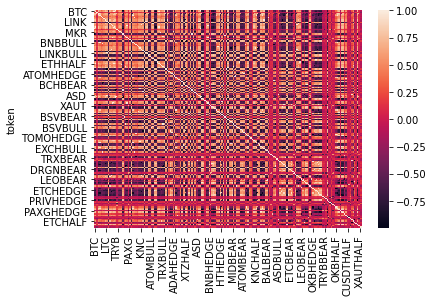

In [108]:
sns.heatmap(corr_df)

In [109]:
corr_df.to_csv('dataset/curated/correlation.csv', index=True)

In [125]:
price_df.to_csv('dataset/curated/price.csv', index=True)